In [1]:
import pandas as pd 
import numpy as np 
import string
import nltk 
import re
import joblib
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split,GridSearchCV


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\apasi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\apasi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score, classification_report, log_loss, plot_confusion_matrix

import matplotlib.pyplot as plt

In [ ]:
dataset = pd.read_csv("drive/MyDrive/reviews_train.csv")

In [ ]:
print("DATASET")
print(f'Shape of training data: {dataset.shape}')

DATASET
Shape of training data: (555791, 9)


In [ ]:
dataset.head()

,reviewerID,asin,reviewerName,helpful,reviewText,summary,unixReviewTime,reviewTime,score
0,A35C43YE9HU9CN,B0064X7B4A,Joan Miller,"[0, 0]",I have decided not to play this game. I can't...,Friends,1396396800,"04 2, 2014",1.0
1,AHFS8CGWWXB5B,B00H1P4V3E,WASH ST. GAMER,"[3, 4]",The Amazon Appstore free app of the day for Ju...,"Amazon Makes This ""Longest Spring Ever"" for Fi...",1402272000,"06 9, 2014",2.0
2,A3EW8OTQ90NVHM,B00CLVW82O,Kindle Customer,"[0, 4]",this game was so mush fun I wish I could play ...,best,1368921600,"05 19, 2013",5.0
3,AJ3GHFJY1IUTD,B007T9WVKM,BrawlMaster4,"[0, 2]","Its pretty fun and very good looking, but you...",Fun Game,1350172800,"10 14, 2012",5.0
4,A3JJGBS4EL603S,B00J206J5E,"K. Wilson ""thesupe""","[0, 0]",good graphics; immersive storyline; hard to st...,great game!,1396915200,"04 8, 2014",5.0


In [ ]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555791 entries, 0 to 555790
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      555791 non-null  object 
 1   asin            555791 non-null  object 
 2   reviewerName    555777 non-null  object 
 3   helpful         555791 non-null  object 
 4   reviewText      555783 non-null  object 
 5   summary         555767 non-null  object 
 6   unixReviewTime  555791 non-null  int64  
 7   reviewTime      555791 non-null  object 
 8   score           555791 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 38.2+ MB


In [ ]:
review_missing = dataset[['reviewText', 'summary']].isnull().sum()

In [ ]:
review_missing

reviewText     8
summary       24
dtype: int64

In [ ]:
dataset = dataset.dropna(axis=0, how="any")

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555745 entries, 0 to 555790
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      555745 non-null  object 
 1   asin            555745 non-null  object 
 2   reviewerName    555745 non-null  object 
 3   helpful         555745 non-null  object 
 4   reviewText      555745 non-null  object 
 5   summary         555745 non-null  object 
 6   unixReviewTime  555745 non-null  int64  
 7   reviewTime      555745 non-null  object 
 8   score           555745 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 42.4+ MB


In [ ]:
dataset = dataset[['reviewText', 'summary', 'score']]

In [ ]:
train, test = train_test_split(dataset, test_size=0.25)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416808 entries, 385374 to 388259
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   reviewText  416808 non-null  object 
 1   summary     416808 non-null  object 
 2   score       416808 non-null  float64
dtypes: float64(1), object(2)
memory usage: 12.7+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138937 entries, 88133 to 98659
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   reviewText  138937 non-null  object 
 1   summary     138937 non-null  object 
 2   score       138937 non-null  float64
dtypes: float64(1), object(2)
memory usage: 4.2+ MB


In [ ]:
def convert_and_prepare_data(df : pd.DataFrame) -> pd.DataFrame:
    newdf = df.copy()
    # prepare text, delete punctuation and stop words
    newdf['tokenized'] = newdf.reviewText.apply(lambda x : word_tokenize(x))
    newdf['tokenized'] = newdf['tokenized'].apply(lambda x : np.array([word for word in x if word.isalnum()]) )
    newdf['tokenized'] = newdf['tokenized'].apply(lambda x : np.array([word for word in x if word not in STOP_WORDS]) )
    # lemmatizing and stemming
    ps = PorterStemmer()
    wnl = WordNetLemmatizer()
    newdf['tokenized'] = newdf['tokenized'].apply(lambda x : np.array([wnl.lemmatize(ps.stem(i.lower())) for i in x]) )
    #count final words number
    newdf['count_words'] = newdf['tokenized'].apply(lambda x : len(x))
    # delete recurring words - to check
    newdf['unique_words'] = newdf['tokenized'].apply(lambda x : np.unique(x))
    # create text from words 
    newdf['new_text'] = newdf['unique_words'].apply(lambda x : ' '.join(x))
    return newdf

In [ ]:
trainDf = convert_and_prepare_data(train)

In [ ]:
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416808 entries, 385374 to 388259
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   reviewText    416808 non-null  object 
 1   summary       416808 non-null  object 
 2   score         416808 non-null  float64
 3   tokenized     416808 non-null  object 
 4   count_words   416808 non-null  int64  
 5   unique_words  416808 non-null  object 
 6   new_text      416808 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 25.4+ MB


In [ ]:
target = trainDf.score.value_counts()

In [ ]:
target

5.0    211470
4.0     87174
3.0     47948
1.0     45000
2.0     25216
Name: score, dtype: int64

In [ ]:
trainDf.to_csv('train.csv')

In [ ]:
countVectorizer = CountVectorizer()
trainCV = countVectorizer.fit_transform(trainDf['new_text'])

tfVectorizer = TfidfVectorizer(min_df = 2, max_df = 0.5, ngram_range= (1,2))
trainTF = tfVectorizer.fit_transform(trainDf['new_text'])

In [ ]:
trainTF.shape

(416808, 414210)

In [ ]:
def get_best_model(model, parameters, X_train, y_train):
    gs = GridSearchCV(
        model,
        parameters,
        cv = 4,  #cross-validation splitting
        n_jobs = -1, #using all processors, 
        return_train_score = True
    )
    best_model = gs.fit(X_train, y_train)
    return best_model

In [ ]:
models={'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier()}
        #'K-NN': KNeighborsClassifier(),
        #'Random Forest': RandomForestClassifier()}
parameters={
      'Logistic Regression':{
                              "C":np.logspace(-3,3,7), 
                              "penalty":["l1","l2"]},
            

        'Decision Tree':{
             'criterion' :['gini', 'entropy'], 
             'splitter':['best', 'random'], 
              'max_depth' : [4,5,6,7,8],
              'max_features': ['auto', 'sqrt', 'log2']}

      #   'K-NN':  { 
      #         'n_neighbors': [3,5,8,10,12], 
      #         'weights': ['uniform', 'distance'],
      #         'metric': ['euclidean', 'manhattan']},
            
        # 'Random Forest': { 
        #                 'n_estimators': [100, 200, 350, 500],
        #                 'max_features': ['auto', 'sqrt', 'log2'],
        #                 'max_depth' : [4,5,6,7,8],
        #                 'criterion' :['gini', 'entropy']}
}

In [ ]:
def get_best_models(models,parameters,  X_trainCV, X_trainTF, y_train):
    best_models_cv = {}
    best_models_tf = {}
    for name, model in models.items():
        print('##### ' + name + ' #####')
        
        best_cv = get_best_model(model,parameters[name], X_trainCV,y_train)
        filename = f'drive/MyDrive/models2/{name}_cv.sav'
        joblib.dump(best_cv, filename)
        best_models_cv[name] = best_cv
        
        best_tf = get_best_model(model,parameters[name],X_trainTF ,y_train)
        filename = f'drive/MyDrive/models2/{name}_tf.sav'
        joblib.dump(best_tf, filename)
        best_models_tf[name] = best_tf

    return best_models_cv, best_models_tf

In [ ]:
def save_models(models):
    for name, model in models.items():
        filename = f'models/{name}_tf.sav'
        joblib.dump(model, filename)

In [ ]:
best_models_cv, best_models_tf = get_best_models(models,parameters, trainCV, trainTF, trainDf.score)

##### Logistic Regression #####


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the num

##### Decision Tree #####


In [ ]:
def save_models2(models):
    for name, model in models.items():
        filename = f'models/{name}_cv.sav'
        joblib.dump(model, filename)

save_models(best_models_tf)
save_models2(best_models_cv)

In [ ]:
lr = LogisticRegression(C=best_models_cv['Logistic Regression'].best_params_['C'], penalty=best_models_cv['Logistic Regression'].best_params_['penalty'])
lr_fited=lr.fit(trainCV, trainDf.score)
joblib.dump(lr_fited, 'best_models/logistic_regression_CV.sav')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


['best_models/logistic_regression_CV.sav']

In [ ]:
dtree = DecisionTreeClassifier(criterion=best_models_cv['Decision Tree'].best_params_['criterion'], splitter=best_models_cv['Decision Tree'].best_params_['splitter'], max_depth = best_models_cv['Decision Tree'].best_params_['max_depth'], max_features=best_models_cv['Decision Tree'].best_params_['max_features']) 
dtree_fitted=dtree.fit(trainCV, trainDf.score)
joblib.dump(dtree_fitted, 'best_models/decision_tree_cv.sav')

['best_models/decision_tree_cv.sav']

In [ ]:
def test_model(filename, X_train, y_train):
    
    clf = joblib.load(filename)
    y_train_pred = clf.predict(X_train)
    class_report = classification_report(y_train,y_train_pred)
    
    cm = confusion_matrix(y_train,y_train_pred)
    fig = plt.figure()
    plot_confusion_matrix(clf, X_train, y_train, values_format = '.5g')
    plt.savefig(f"metrics/{filename[12:-4]}.png")

    acc = accuracy_score(y_train,y_train_pred)
    f1 = f1_score(y_train,y_train_pred, average='macro')
    #loss = log_loss(y_train, y_train_pred)
  
    
    print("Confusion matrix")
    print(cm)
    print("_"*50)
    print("REPORT: ")
    print(class_report)
    print("Accuracy score: {}%".format(round(acc,2)*100))
    print("F1 score: {}".format(f1))
    #print("Cross entropy loss: {}".format(loss))

    return acc, f1

In [ ]:
def test_multiple_models(names, filenames, X_train, y_train, suffix):
  x_ticks = []
  models_acc = []
  models_f1 = []
  #models_loss = []
  for name, filename in zip(names, filenames):
    print("##########", name, "########")
    acc, f1 = test_model(filename, X_train, y_train)
    x_ticks.append(name)
    models_acc.append(acc)
    models_f1.append(f1)
    #models_loss.append(loss)
  #make_charts(x_ticks, models_acc, models_f1, models_loss, suffix)

Count Vectorizer
########## Logistic Regression ########
Confusion matrix
[[ 30448   1423   3101   1514   8514]
 [  8340   3064   4728   2239   6845]
 [  5886   1358  14303   8240  18161]
 [  2926    559   5799  22792  55098]
 [  3808    419   3151  11807 192285]]
__________________________________________________
REPORT: 
              precision    recall  f1-score   support

         1.0       0.59      0.68      0.63     45000
         2.0       0.45      0.12      0.19     25216
         3.0       0.46      0.30      0.36     47948
         4.0       0.49      0.26      0.34     87174
         5.0       0.68      0.91      0.78    211470

    accuracy                           0.63    416808
   macro avg       0.54      0.45      0.46    416808
weighted avg       0.59      0.63      0.59    416808

Accuracy score: 63.0%
F1 score: 0.4613415838094978
########## Decision Tree ########


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix
[[     0      0      5      3  44992]
 [     0      0      1      1  25214]
 [     0      0     14      2  47932]
 [     0      0     10     22  87142]
 [     0      0      7      7 211456]]
__________________________________________________
REPORT: 
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00     45000
         2.0       0.00      0.00      0.00     25216
         3.0       0.38      0.00      0.00     47948
         4.0       0.63      0.00      0.00     87174
         5.0       0.51      1.00      0.67    211470

    accuracy                           0.51    416808
   macro avg       0.30      0.20      0.13    416808
weighted avg       0.43      0.51      0.34    416808

Accuracy score: 51.0%
F1 score: 0.13485879473245505


<Figure size 432x288 with 0 Axes>

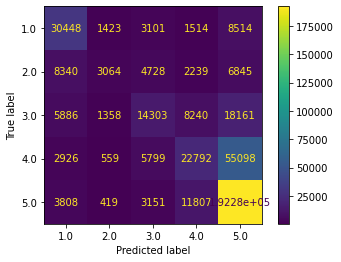

<Figure size 432x288 with 0 Axes>

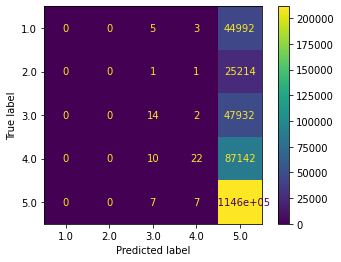

In [ ]:
print("Count Vectorizer")
names = ["Logistic Regression", "Decision Tree"]
filnames = ["best_models/logistic_regression_CV.sav", "best_models/decision_tree_cv.sav"]
test_multiple_models(names,filnames , trainCV, trainDf.score, 'CV')

In [ ]:
lr = LogisticRegression(C=best_models_tf['Logistic Regression'].best_params_['C'], penalty=best_models_tf['Logistic Regression'].best_params_['penalty'])
lr_fited=lr.fit(trainTF, trainDf.score)
joblib.dump(lr_fited, 'best_models/logistic_regression_tf.sav')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


['best_models/logistic_regression_tf.sav']

In [ ]:
dtree = DecisionTreeClassifier(criterion=best_models_tf['Decision Tree'].best_params_['criterion'], splitter=best_models_tf['Decision Tree'].best_params_['splitter'], max_depth = best_models_tf['Decision Tree'].best_params_['max_depth'], max_features=best_models_tf['Decision Tree'].best_params_['max_features']) 
dtree_fitted=dtree.fit(trainTF, trainDf.score)
joblib.dump(dtree_fitted, 'best_models/decision_tree_tf.sav')

['best_models/decision_tree_tf.sav']

Term Frequency-Inverse Document Frequency
########## Logistic Regression ########
Confusion matrix
[[ 31411   1160   2769   1711   7949]
 [  7548   4026   4387   2398   6857]
 [  5204   1145  16296   7569  17734]
 [  2645    541   4686  27678  51624]
 [  3283    312   2528   9481 195866]]
__________________________________________________
REPORT: 
              precision    recall  f1-score   support

         1.0       0.63      0.70      0.66     45000
         2.0       0.56      0.16      0.25     25216
         3.0       0.53      0.34      0.41     47948
         4.0       0.57      0.32      0.41     87174
         5.0       0.70      0.93      0.80    211470

    accuracy                           0.66    416808
   macro avg       0.60      0.49      0.51    416808
weighted avg       0.64      0.66      0.62    416808

Accuracy score: 66.0%
F1 score: 0.5055524513268477
########## Decision Tree ########
Confusion matrix
[[   802      0      2      3  44193]
 [   128      2     1

<Figure size 432x288 with 0 Axes>

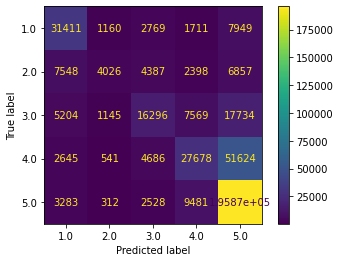

<Figure size 432x288 with 0 Axes>

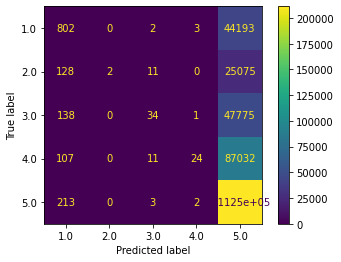

In [ ]:
print("Term Frequency-Inverse Document Frequency")
names = ["Logistic Regression", "Decision Tree"]
filnames = ["best_models/logistic_regression_tf.sav", "best_models/decision_tree_tf.sav"]
test_multiple_models(names,filnames , trainTF, trainDf.score, 'TF')

In [ ]:
testDf = convert_and_prepare_data(test)
testTF = tfVectorizer.transform(testDf['new_text'])

In [ ]:
testTF.shape

(138937, 414210)

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
